In [1]:
# Read in FC and demographics
# We have four "demographics":
# 1. Age (8-23 years old)
# 2. Sex (2 values)
# 3. Race (2 values)
# 4. Scanner task (3 values)

import pickle
import numpy as np

# Load our sample FC data and demographics
sample = pickle.load(open('/home/anton/Documents/Tulane/Research/DemoVAE/sample_dict.pkl', 'rb'))

fc = []
age = []
sex = []
race = []
task = []

# Put in numpy format
# Each subject has a rest, nback, and emoid scan

demo_types = ['continuous', 'categorical', 'categorical', 'categorical']

for i,sub in enumerate(sample['rest']):
    fc.append(sample['rest'][sub])
    fc.append(sample['nback'][sub])
    fc.append(sample['emoid'][sub])
    age.append(sample['age'][sub])
    age.append(sample['age'][sub])
    age.append(sample['age'][sub])
    sex.append(sample['sex'][sub])
    sex.append(sample['sex'][sub])
    sex.append(sample['sex'][sub])
    race.append(sample['race'][sub])
    race.append(sample['race'][sub])
    race.append(sample['race'][sub])
    task.append(0)
    task.append(1)
    task.append(2)

fc = np.stack(fc)
age = np.array(age)
sex = np.array(sex)
race = np.array(race)
task = np.array(task)

demo = [age, sex, race, task]

print(fc.shape, age.shape)

(3579, 34716) (3579,)


In [2]:
# Load and run the DemoVAE model
# If you installed DemoVAE from pip, you do not need to add the demovae src folder to path

import sys

p = '../pip/src'

if p not in sys.path:
    sys.path.append(p)
    print(sys.path)

# Import DemoVAE

from demovae import DemoVAE

# Run our model with some non-default parameters
# I checked and these give good results for the sample data
# To see all possible parameters, take a look at the file src/demovae/sklearn.py
# Running without CUDA will take at least 5 hours to train the model

# Create the model

vae = DemoVAE(pperiod=10, use_cuda=False, nepochs=3000, latent_dim=60, weight_decay=0, lr=1e-4, loss_rec_mult=100, loss_decor_mult=10)

# Fit the model to data

vae.fit(fc, demo, demo_types)

['/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/usr/lib/python3.12/site-packages', '../pip/src']
Fitting auxilliary guidance model for demographic 0 continuous... done
Fitting auxilliary guidance model for demographic 1 categorical... done
Fitting auxilliary guidance model for demographic 2 categorical... done
Fitting auxilliary guidance model for demographic 3 categorical... done
Converting input to pytorch
Converting demographics to pytorch
Beginning VAE training
Epoch 0 ReconLoss 0.5635 CovarianceLoss 128.2765 MeanLoss 0.0734 DecorLoss 7.2746 GuidanceTargets [15.154245376586914, 1, 0, 1, 0, 0, 1, 0] GuidanceLosses ['3.7497', '59.6723', '59.6723', '11.7112', '11.7112', '19.5808', '19.5808', '19.5808'] 
Epoch 0 ReconLoss 0.5667 CovarianceLoss 833.1334 MeanLoss 0.8584 DecorLoss 1.884 GuidanceTargets [11.741453170776367, 0, 1, 1, 0, 0, 1, 0] GuidanceLosses ['3.7962', '323.1384', '323.1384', '0.0', '0.0', '0.0566', '0.0566', '0.0566'] 
Epoch 0 R

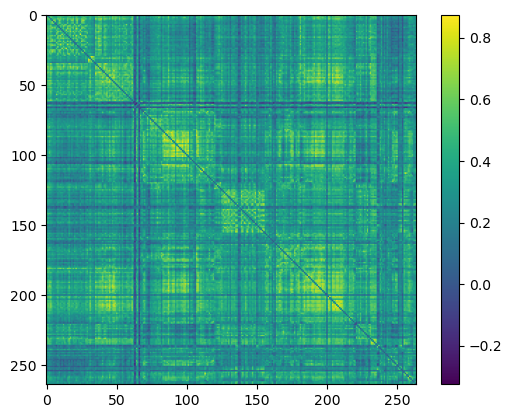

In [3]:
# Display reconstruction of original data
# Note we use Power atlas with 264 regions of interest
# Input to model is the vectorized upper right triangle 
# omitting the main diagonal of ones

import matplotlib.pyplot as plt

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

xx = vae.transform(fc, demo, demo_types)

plt.imshow(vec2mat(xx[14]))
plt.colorbar()

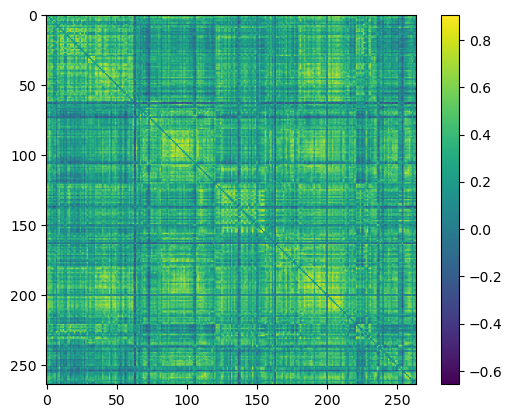

In [28]:
# Compare to original FC data

plt.imshow(vec2mat(fc[14]))
plt.colorbar()

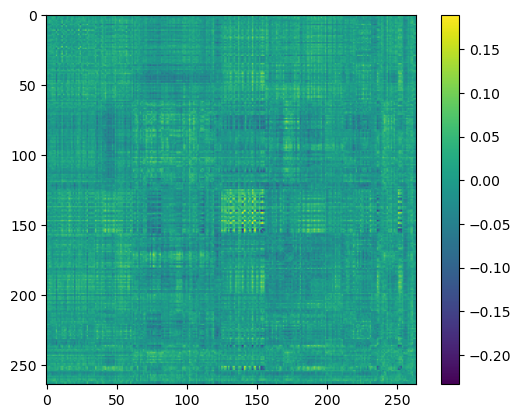

In [11]:
# Generate synthetic data to test group differences
# Here we generate 500 samples of female European ancestry 14 year olds
# With 1) the resting state scan or 2) with the working memory (nback) scan

n = 500

xx = vae.transform(n, [14*np.ones(n), np.zeros(n), np.zeros(n), np.zeros(n)], demo_types)
yy = vae.transform(n, [14*np.ones(n), np.zeros(n), np.zeros(n), np.ones(n)], demo_types)

# Take the means of each group and look at group differences

diff = np.mean(xx, axis=0)-np.mean(yy, axis=0)

plt.imshow(vec2mat(diff))
plt.colorbar()

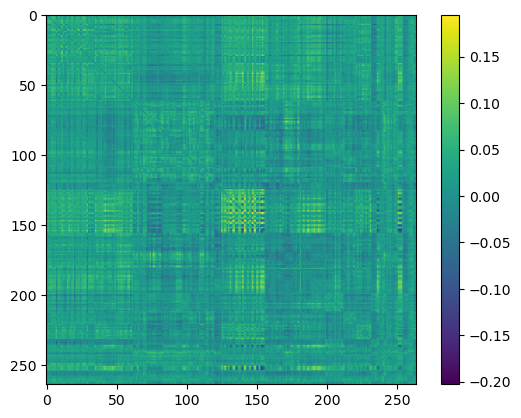

In [12]:
# Look at ground truth group differences from original FC data
# Here "young" and "old" are just group 1 and group 2
# Group 1 is nback scan
# Group 2 is resting state scan
# Difference should look similar to plot above

young = []
old = []

for i,sub in enumerate(sample['rest']):
    old.append(sample['rest'][sub])
    young.append(sample['nback'][sub])
    # if sample['race'][sub] == 1:
    #     old.append(sample['rest'][sub])
    # else:
    #     young.append(sample['rest'][sub])
    # if sample['sex'][sub] == 0 or sample['race'][sub] == 1:
    #     continue
    # if sample['sex'][sub] < 10:
    #     young.append(sample['rest'][sub])
    # elif sample['age'][sub] > 20:
    #     old.append(sample['rest'][sub])

young = np.mean(np.stack(young), axis=0)
old = np.mean(np.stack(old), axis=0)

plt.imshow(vec2mat(old-young))
plt.colorbar()